<a href="https://colab.research.google.com/github/YuukiHnf/GaussianProcess/blob/main/kernelRegressionWithParameterOpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [ ]:
class KernelRegresson(nn.Module):
  def __init__(self, kernel, x_train, y_train):
    self.kernel = kernel
    self.x_train = x_train.clone()
    self.y_train = y_train.clone() - y_train.mean()
    self.y_mean = y_train.mean().clone()
    self.N = len(x_train)
    self.K = torch.tensor(
        np.array([ kernel(xi,xj) for xi in self.x_train for xj in self.x_train]).reshape(self.N,self.N)
        , dtype=torch.float32)
    self.K.require_grad = True
    self.K_inv = torch.inverse(self.K)
    self.yy = self.K_inv.mv(self.y_train)

  def predict(self, x_test):
    k_ = torch.from_numpy(np.array([[ self.kernel(x, x_test) for x in self.x_train ]])).float().reshape(self.N)
    k__ = torch.tensor(self.kernel(x_test, x_test))
    mu = k_.dot(self.yy)
    sig = k__ - k_.dot( self.K_inv.mv(k_) )
    return [mu+self.y_mean, sig]

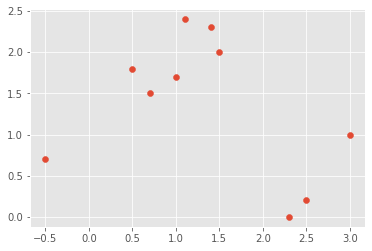

In [ ]:
x_train = torch.tensor([-0.5,0.5,1,1.4,3,2.3,2.5	,1.5,1.1,0.7])
y_train = torch.tensor([0.7,1.8,1.7,	2.3,1,	0,	0.2,	2,	2.4,1.5])
plt.style.use('ggplot')
plt.scatter(x_train, y_train)

In [ ]:
def kgauss(xi,xj,theta1=1.0, theta2=0.4, theta3=0.1):
  return torch.tensor( theta1 * torch.exp(- (xi - xj)*(xi - xj) / theta2 ) ) + theta3*(xi == xj)

In [ ]:
GP = KernelRegresson(kgauss, x_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
x_index = torch.linspace(-1,4,100)
pred_mean_std = torch.tensor(np.array([GP.predict(x) for x in x_index]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
pred_mean_std.shape

torch.Size([100, 2])

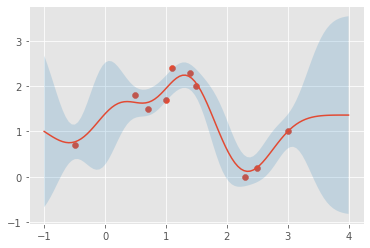

In [ ]:
pred_mean = pred_mean_std[:,0]
pred_std = pred_mean_std[:,1]

plt.scatter(x_train, y_train)
plt.plot(x_index, pred_mean)
plt.fill_between(x_index, pred_mean - 2*pred_std, pred_mean + 2*pred_std, alpha=0.2)

In [ ]:
from numpy.random import multivariate_normal as mvnrand

In [ ]:
from torch.autograd import Variable

In [ ]:
class KernelRegresson_paramOpt(nn.Module):
  def __init__(self, kernel, x_train, y_train):
    super(KernelRegresson_paramOpt, self).__init__()
    self.kernel = kernel
    self.x_train = x_train.clone()
    self.y_train = y_train.clone() - y_train.mean()
    self.y_mean = y_train.mean().clone()
    self.N = len(x_train)
    self.theta1 = Variable(torch.tensor(1.0), requires_grad=True)
    self.theta2 = Variable(torch.tensor(0.5), requires_grad=True)
    self.theta3 = Variable(torch.tensor(0.5), requires_grad=True)
    print(self.theta1)
    print(self.theta2)
    print(self.theta3)
    self.K = torch.zeros((self.N,self.N))
    

  def forward(self):
    self.fit()
    return dist.multivariate_normal(torch.zeros(self.N), self.K)
  
  def log_likelihood(self):
    K = self.fit()
    K_inv = torch.inverse(K)
    K_inv.retain_grad()
    #print(K_inv)
    likelihood = -torch.log(K) - K_inv.mv(self.y_train).dot(self.y_train)
    likelihood.retain_grad()
    S = -likelihood.mean()
    #print(likelihood)
    S.retain_grad()
    return S

  def predict(self, x_test):
    self.K = self.fit()
    self.K_inv = torch.inverse(self.K)
    self.yy = self.K_inv.mv(self.y_train)
    k_ = torch.tensor(np.array([[ self.kernel(x, x_test, self.theta1, self.theta2, self.theta3) for x in self.x_train ]]).astype(np.float32), dtype=torch.float32).reshape(self.N)
    k__ = torch.tensor(self.kernel(x_test, x_test, self.theta1, self.theta2, self.theta3))
    #k__ = self.kernel(x_test, x_test)
    mu = k_.dot(self.yy)
    sig = k__ - k_.dot( self.K_inv.mv(k_) )
    return [mu+self.y_mean, sig]
  
  def fit(self):
    K = torch.zeros((self.N,self.N))
    for i in range(self.N):
      for j in range(self.N):
        K[i][j] = self.kernel( x_train[i], x_train[j] ,self.theta1, self.theta2, self.theta3)
        K[i][j].retain_grad()
    return K



In [ ]:
def kgauss(xi,xj,theta1=1.0, theta2=0.4, theta3=0.1):
  z = torch.exp(- (xi - xj)*(xi - xj)) 
  y = torch.exp(theta1) * z / torch.exp(theta2) + torch.exp(theta3) * torch.tensor( xi == xj)
  return y

In [ ]:
type(x_index[1])

torch.Tensor

In [ ]:
model = KernelRegresson_paramOpt(kgauss, x_train, y_train)
model.cuda()
optimizer = torch.optim.SGD(params=[model.theta1, model.theta2, model.theta3], lr=1e-2)

his = {'loss':[], 'theta1':[], 'theta2':[], 'theta3':[] }

for i in range(300):
  optimizer.zero_grad()
  loss = model.log_likelihood()
  loss.backward()
  optimizer.step()
  his['theta1'].append(model.theta1)
  his['theta2'].append(model.theta2)
  his['theta3'].append(model.theta3)
  his['loss'].append(loss)
  if (i+1)%100 == 0:
    print(loss)

tensor(0.5000, requires_grad=True)
tensor(0.5000, requires_grad=True)
tensor(0.5000, requires_grad=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


tensor(-1.4742, grad_fn=<NegBackward>)
tensor(-3.4714, grad_fn=<NegBackward>)
tensor(-5.2611, grad_fn=<NegBackward>)


In [ ]:
model.theta2

tensor(27.0410, requires_grad=True)

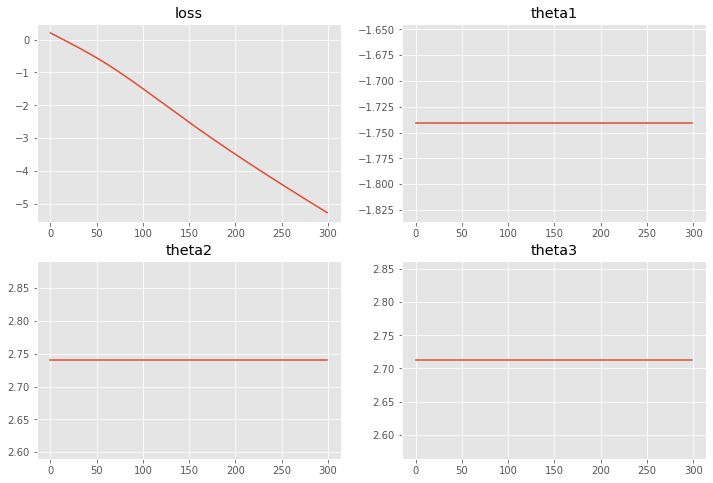

In [ ]:
fig = plt.figure(figsize=(12,8))
for i, (key, values) in enumerate(his.items()):
  ax = fig.add_subplot(2,2,i+1)
  ax.plot(his[key])
  ax.set_title(f'{key}')

plt.show()

## 最適化がうまくいかなかった図3.22

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


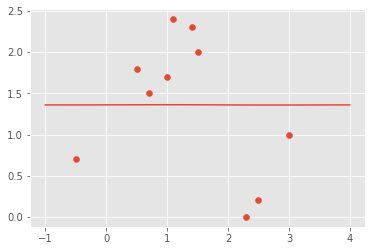

In [ ]:
pred_mean_std = torch.tensor(np.array([model.predict(x) for x in x_index]).astype(np.float32))
pred_mean = pred_mean_std[:,0]
pred_std = pred_mean_std[:,1]

plt.scatter(x_train, y_train)
plt.plot(x_index, pred_mean)
#plt.fill_between(x_index, pred_mean - pred_std, pred_mean + pred_std, alpha=0.2)

In [ ]:
class KernelRegresson_paramOpt(nn.Module):
  def __init__(self, kernel, x_train, y_train):
    super(KernelRegresson_paramOpt, self).__init__()
    self.kernel = kernel
    self.x_train = x_train.clone()
    self.y_train = y_train.clone() - y_train.mean()
    self.y_mean = y_train.mean().clone()
    self.N = len(x_train)
    self.theta1 = Variable(torch.tensor(1.5), requires_grad=True)
    self.theta2 = Variable(torch.tensor(2.0), requires_grad=True)
    self.theta3 = Variable(torch.tensor(0.5), requires_grad=True)
    print(self.theta1)
    print(self.theta2)
    print(self.theta3)
    self.K = torch.zeros((self.N,self.N))
    

  def forward(self):
    self.fit()
    return dist.multivariate_normal(torch.zeros(self.N), self.K)
  
  def log_likelihood(self):
    K = self.fit()
    K_inv = torch.inverse(K)
    K_inv.retain_grad()
    #print(K_inv)
    likelihood = -torch.log(K) - K_inv.mv(self.y_train).dot(self.y_train)
    likelihood.retain_grad()
    S = -likelihood.mean()
    #print(likelihood)
    S.retain_grad()
    return S

  def predict(self, x_test):
    self.K = self.fit()
    self.K_inv = torch.inverse(self.K)
    self.yy = self.K_inv.mv(self.y_train)
    k_ = torch.tensor(np.array([[ self.kernel(x, x_test, self.theta1, self.theta2, self.theta3) for x in self.x_train ]]).astype(np.float32), dtype=torch.float32).reshape(self.N)
    k__ = torch.tensor(self.kernel(x_test, x_test, self.theta1, self.theta2, self.theta3))
    #k__ = self.kernel(x_test, x_test)
    mu = k_.dot(self.yy)
    sig = k__ - k_.dot( self.K_inv.mv(k_) )
    return [mu+self.y_mean, sig]
  
  def fit(self):
    K = torch.zeros((self.N,self.N))
    for i in range(self.N):
      for j in range(self.N):
        K[i][j] = self.kernel( x_train[i], x_train[j] ,self.theta1, self.theta2, self.theta3)
        K[i][j].retain_grad()
    return K


In [ ]:
model = KernelRegresson_paramOpt(kgauss, x_train, y_train)
model.cuda()
optimizer = torch.optim.SGD(params=[model.theta1, model.theta2, model.theta3], lr=1e-5)

his = {'loss':[], 'theta1':[], 'theta2':[], 'theta3':[] }

for i in range(3000):
  optimizer.zero_grad()
  loss = model.log_likelihood()
  loss.backward()
  optimizer.step()
  his['theta1'].append(model.theta1)
  his['theta2'].append(model.theta2)
  his['theta3'].append(model.theta3)
  his['loss'].append(loss)
  if (i+1)%100 == 0:
    print(f'{i+1}:{loss}')

tensor(1.5000, requires_grad=True)
tensor(2., requires_grad=True)
tensor(0.5000, requires_grad=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


100:0.12535643577575684
200:0.12278024852275848
300:0.12020516395568848
400:0.11763553321361542
500:0.11506907641887665
600:0.11250298470258713
700:0.10993827879428864
800:0.10737467557191849
900:0.10481060296297073
1000:0.10225618630647659
1100:0.09970392286777496
1200:0.09715312719345093
1300:0.09460282325744629
1400:0.09205391258001328
1500:0.08950655162334442
1600:0.08696971833705902
1700:0.0844326764345169
1800:0.08189603686332703
1900:0.07936042547225952
2000:0.07682523131370544
2100:0.07429327070713043
2200:0.07176671922206879
2300:0.06924071162939072
2400:0.06671517342329025
2500:0.06419109553098679
2600:0.06166737899184227
2700:0.05914333462715149
2800:0.056629475206136703
2900:0.05411667749285698
3000:0.051604870706796646


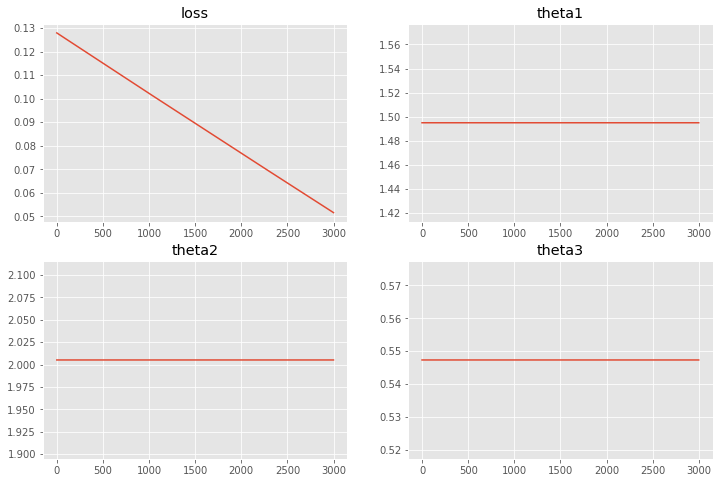

In [ ]:
fig = plt.figure(figsize=(12,8))
for i, (key, values) in enumerate(his.items()):
  ax = fig.add_subplot(2,2,i+1)
  ax.plot(his[key])
  ax.set_title(f'{key}')

plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


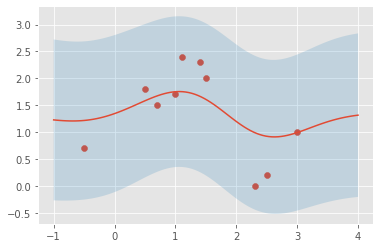

In [ ]:
pred_mean_std = torch.tensor(np.array([model.predict(x) for x in x_index]).astype(np.float32))
pred_mean = pred_mean_std[:,0]
pred_std = pred_mean_std[:,1]

plt.scatter(x_train, y_train)
plt.plot(x_index, pred_mean)
plt.fill_between(x_index, pred_mean - torch.sqrt(pred_std), pred_mean + torch.sqrt(pred_std), alpha=0.2)